# Sample size determination for experiment *Brisbane*

This notebook presents the results of a set of simulations to determine the sample size in experiment *Brisbane*. To reduce clutter, all the necessary code for these calculations is inside the accompanying `utils.py` module, which is imported here. 

In [1]:
%matplotlib inline

import utils

For reproducibility, I am using random seeds. These will guarantee that the same random numbers, and so the same actual results, occur every time. Obviously, these seeds can be changed aribtrarily and the ultimate conclusions should not differ other than in trivial ways. 

In [2]:
auctest_random_seed, powertest_random_seed = 42, 101

The main calculations below are computationally intensive, and also require parallel processing. They can be skipped by setting `use_cached_data` to `True`, which will then load in precomputed results based on specified random seeds.

In [3]:
use_cached_data = True

## The nature of the experiment, the main question, and the main analysis

In each block of experiment *Brisbane*, subjects will first either read a short text or be shown a list of words. Their memory will then be tested either by a recognition test or a recall test.  The main focus of the analysis will be on whether the probability of remembering (or falsely remembering) any given word in the text or the word list can be predicted by a Bayesian probabilistic model of memory. 

For simplicity, in what follows, I will use the term "text" to refer to either a text per se or a word list. In other words, "text" refers generally to the stimuli they were asked to remember.

The Bayesian model's predictions will be tested using logistic regression. For example, the model's prediction of whether the the word shown on trial $i$ is remembered can be denoted by $\phi_i$. Whether the subject of trial $i$ says the the word was in the text they were just shown can be denoted by $y_i$, where $y_i = 1$ means that the subject said the word was present (or, using the terminology of some memory experiments, that the test word is *old*) and $y_i = 0$ means that the subject said the word was not present (or the word is *new*).

We can then model how well $\phi_i$ predicts $y_i$ using a multlievel logistic regression like 

$$
\log\left( \frac{\mathrm{P}(y_i = 1)}{1-\mathrm{P}(y_i = 1)}\right) = \alpha_i + \beta_i \phi_i,\quad\text{for $i \in 1...N$}
$$
where
$$
\begin{align}
\alpha_i &= a^0 + a^s_{\text{subject}[i]}  + a^t_{\text{text}[i]},\\
\beta_i  &= b^0 + b^s_{\text{subject}[i]}   + b^t_{\text{text}[i]}.
\end{align}
$$

Here, $\text{subject}[i] \in 1 \cdots J $ indicates the identity of the subject on trial $i$, and $\text{text}[i] \in 1\cdots K$ indicates the identity of the textof trial $i$.

The random effects that model inter-subject and inter-text variability are 
$$
\begin{align}
a^s_j &\sim N(0, \tau^2_{a_\text{subject}}),\quad b^s_j \sim N(0, \tau^2_{b_\text{subject}})\quad j \in 1 \ldots J,\\
a^t_k &\sim N(0, \tau^2_{a_\text{text}}),\quad b^t_k \sim N(0, \tau^2_{b_\text{text}})\quad k \in 1 \ldots K.
\end{align}
$$

The question of sample size addresses how many subjects $J$ and texts $K$ we will need to identify and non-null effect of the probabilistic model, i.e. $\phi_i$, on the probability of remembering a word. 

### Possible effect sizes

If we can predict memory responses from computational/mathematical models of memory, it is not likely to be only a small effect. For example, Roediger, Watson, McDermott, and Gallo (2001) found a high correlation (around r=0.7) between false memories for crticial words and associative connections to this word from words in the word list. For the same phenomenon, Deese (1959) reported correlations of up to r=0.88. We can take these results as evidence that it is possible for computational/mathematical models, e.g. associative network models in Roediger et al's or Deese's case, to be strongly predictive of memories for individual items.

On the other hand, Roediger et al. and Deese were focusing on memories for only certain types of words, namely their *critical lure* words. The correlation between their associative network models and memories, whether false or veridical, of other words might be more modest. 

Also, if we are interested in the comparing the *relative* predictive power of a computational/mathematical model, i.e., how well it predicts memory relative to another model, we may be expecting relatively small effects. 

As such, we need consider a range of possible effect size, from relatively high to relatively low. 

### Quantifying effect sizes in logistic regression

One way to quantify effects of a predictor $x_i$ in logistic regression is by the Area Under the Curve (AUC). Amongst other things, this quantity is formally identical to the probability that the $x_i$ that corresponds to a $y_i$ where $y_i=1$ is greater than $x_j$ where $y_j=0$. In other words, if the AUC value is very high, e.g. close to 1.0, all the predictors that correspond to responses equal to 1 will be greater than the predictors that correspond to responses equal to 0.

In a simple logistic regression model, i.e., with one predictor and no random effects, if we standardize the predictor to have a mean of zero, standard deviation of 1.0, then we see a clear relationship between the value of the coefficient for the predictor and the AUC. 

The following simulation generates data from 1000 different simple logistic regression models, using a range of different values for the coefficient for the predictor variable. For each model, we calculate the AUC. Doing around 1000 iterations of the following calculations will take approximately 1 minute.

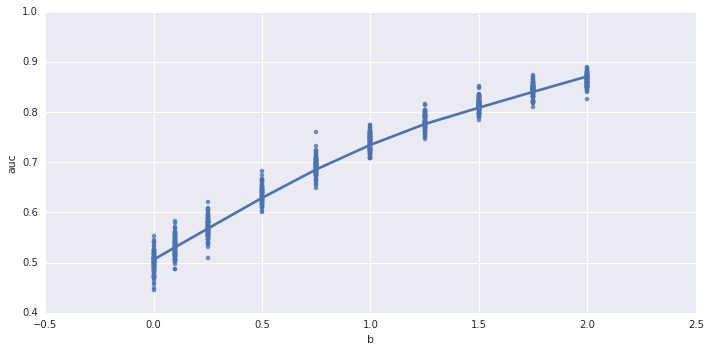

In [4]:
if not use_cached_data:

    b_choices = (0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0)

    auc_df = utils.AucTest.auc(iterations=1000, 
                               b_choices = b_choices, 
                               random_seed=auctest_random_seed)
    auc_df.to_csv(utils.get_save_filename('auc_df', random_seed=auctest_random_seed))
else:
    
    auc_df = utils.pandas.read_csv('auc_df-seed_42-Nov20-1332.csv')

utils.AucTest.aucplot(auc_df)

As can be seen, a coefficient of around 1.0 leads to an AUC of about 0.75, while a coefficient of around 0.25 leads to AUC of around 0.55. As such, the range 0.25, 0.5, 0.75 to 1.0 is a range from approximately small, through approximately medium, to approximately large effects. 


### Sample size determination simulations

There are three main sets of simulations for determining the sample sizes. On each simulation in each set, we create a test data set for a given value of $J$ and $K$, and for a given value of the coefficient for a standardized predictor, i.e. $b^0$ above, and for different amounts of inter-subject and intertext variability, i.e, the $\tau^2_{b_\text{subject}}$ and $\tau^2_{b_\text{text}}$ above. In all case, we'll leave $a^0=0.0$ and set $\tau^2_{a_\text{subject}}$ and $\tau^2_{a_\text{text}}$ to constant values of 0.5. Setting $a^0=0$ is without loss of generality and this will not affect the effect of the $b^0$ predictor. On the other hand, setting $\tau^2_{a_\text{subject}}$ and $\tau^2_{a_\text{text}}$ to 0.5 adds relatively high degree of inter-subject and inter-text variability in average memory performance. These variations are to be expected in our experiment, i.e. some subjects will be better than others, on average, and some texts will be easier or harder than others to remember on average. In all cases, however, these variations will also not affect the effect of of the $b^0$ predictor.

In all simulation sets, we will consider a range of values of $J$ from low (25) to high-ish (150). We also consider a range of effects, mentioned above, from low-ish $0.25$ to high-ish $1.0$. We also consider different amounts of inter-subject and and inter-text variations around these effects. For the inter-subject variation, we consider values of $0.1$, $0.25$, $0.5$ for $\tau_{b_\text{subject}}$ (note, these values are for the standard deviation). For $\tau_{b_\text{text}}$, we consider values of $0.1$ and $0.25$. In all simulations, we assume that there would be 20 items per memory test block. 

* Simulation set 1: In the first simulation set, we consider values of $K$ ranging from 5 to 50. However, we assume that only 3 are seen per subject. In other words, in an experiment, the subject is given only three memory tests or three different texts. These 3 texts are randomly chosen per each subject.

* Simulation set 2: The second simulation set, like the first, considers a range of $K$ from 5 to 50, but with each subject be tested with only 5 of these. 

* Simulation set 3: In the final set, we consider only $K=10$ and all subjects are presented all 10. 

In each simulation, our aim to calculate the probability of detecting an effect of $b^0$. We calculate whether $b^0$ has an effect by calculating the approximate Bayes factor for the multilevel logistic regression model relative to its null counterpart, i.e., an identical model to that shown above but with $b^0=0$. Using the rough guidelines of Kass and Raftery (1995), $2 \log BF > 6.0$ and $2 \log BF > 10$ correspond to *strong* and *very strong* degrees of evidence in favour of model over its null counterpart. The approximate Bayes factors are calculated using the Bayesian information criterion value calculated by the `glmer` in `lme4`. 

Each simulation is relatively computationally intensive and so they need to be run in parallel. I'm using a dual 8-core Xeon E5-2690 (2.9GHz) machine, which gives me 16 physical cores. On this, the first simulation takes around 24hrs, the second around 35hrs, and the third around 24hrs. If you're using a single dual-core or quad-core machine, it is likely to take 8 times or 4 times longer, respectively.

In [5]:
J_choices = (25, 50, 75, 100, 125, 150)
K_choices = (5, 10, 20, 30, 40, 50)
N_choices = (20,)
subject_variation_choices = (0.1, 0.25, 0.5)
text_variation_choices = (0.1, 0.25)
effect_choices = (0.25, 0.5, 0.75, 1.0)

trials = 50000

simulation_settings = dict(
    kmin_3 = (trials, dict(J_choices = J_choices,
                           K_choices = K_choices,
                           K_min_choices = (3,),
                           N_choices = N_choices,
                           subject_variation_choices = subject_variation_choices,
                           text_variation_choices = text_variation_choices,
                           effect_choices = effect_choices
                          )
              ),
    
    kmin_5 = (trials, dict(J_choices = J_choices,
                           K_choices = K_choices,
                           K_min_choices = (5,),
                           N_choices = N_choices,
                           subject_variation_choices = subject_variation_choices,
                           text_variation_choices = text_variation_choices,
                           effect_choices = effect_choices)
              ),
    
    kmax_kmin_10 = (trials/5, dict(J_choices = J_choices,
                                   K_choices = (10,),
                                   K_min_choices = (10,),
                                   N_choices = N_choices,
                                   subject_variation_choices = subject_variation_choices,
                                   text_variation_choices = text_variation_choices,
                                   effect_choices = effect_choices)
                    )
)

In [6]:
if not use_cached_data:
    
    from ipyparallel import Client
    import datetime 

    clients = Client()
    clients.block = True
    view = clients.load_balanced_view()
    
    task_batch = utils.make_task_batches(simulation_settings, random_seed)

    results = {}
    dataframe = {}
    for key in task_batch:
        results[key] = view.map(utils.power_test, task_batch[key])
        dataframe[key] = utils.simulation_results_to_dataframe(results[key])
        dataframe[key].to_csv(utils.get_save_filename(key))

else:
    dataframe = {}
    dataframe['kmin_3'] = utils.pandas.read_csv('kmin_3-seed_101-Nov17-1213.csv', index_col=0)
    dataframe['kmin_5'] = utils.pandas.read_csv('kmin_5-seed_101-Nov20-0021.csv', index_col=0)
    dataframe['kmax_kmin_10'] = utils.pandas.read_csv('kmax_kmin_10-seed_101-Nov18-0908.csv', index_col=0)

## Results

We will first look at the results from the first simulation, i.e. where there were up to $K=50$ texts but each subject was presented only 3. We look at how the probability of getting a (approximate) Bayes Factor of greater than $e^3$, i.e. $2 \log BF > 6.0$, as a function of the different range of values for $K$ (rows of facet plot below) and the different range of values of $J$ (columns of facet plot) and the different range of inter-subject variability (colours of lines), and for the different range of values for the effect size (x axis of each plot). The y-axis gives the probability of getting a Bayes factor greater than the threshold. These probabilities are all calculated from the frequency of the Bayes factors in the simulations being greater than the threshold. We want the probability of having Bayes factors greater than the threshold to be high, at least greater than 0.8, which is the horizontal line shown in each plot.

What is noticable about these plots is that even with relatively large numbers of subjects, the probability of getting Bayes factors above threshold is never sufficiently high, except perhaps at the highest effect sizes, when we are using a low total number of different texts, i.e. when there are only around 5 texts. We need a large number of texts, i.e. at least 20, before results start improving. Using $K=50$ texts and $J = 125$ or $J=150$ gives us very high probability of detecting effects even at low effect sizes and high amounts of inter-subject variability in those effects.

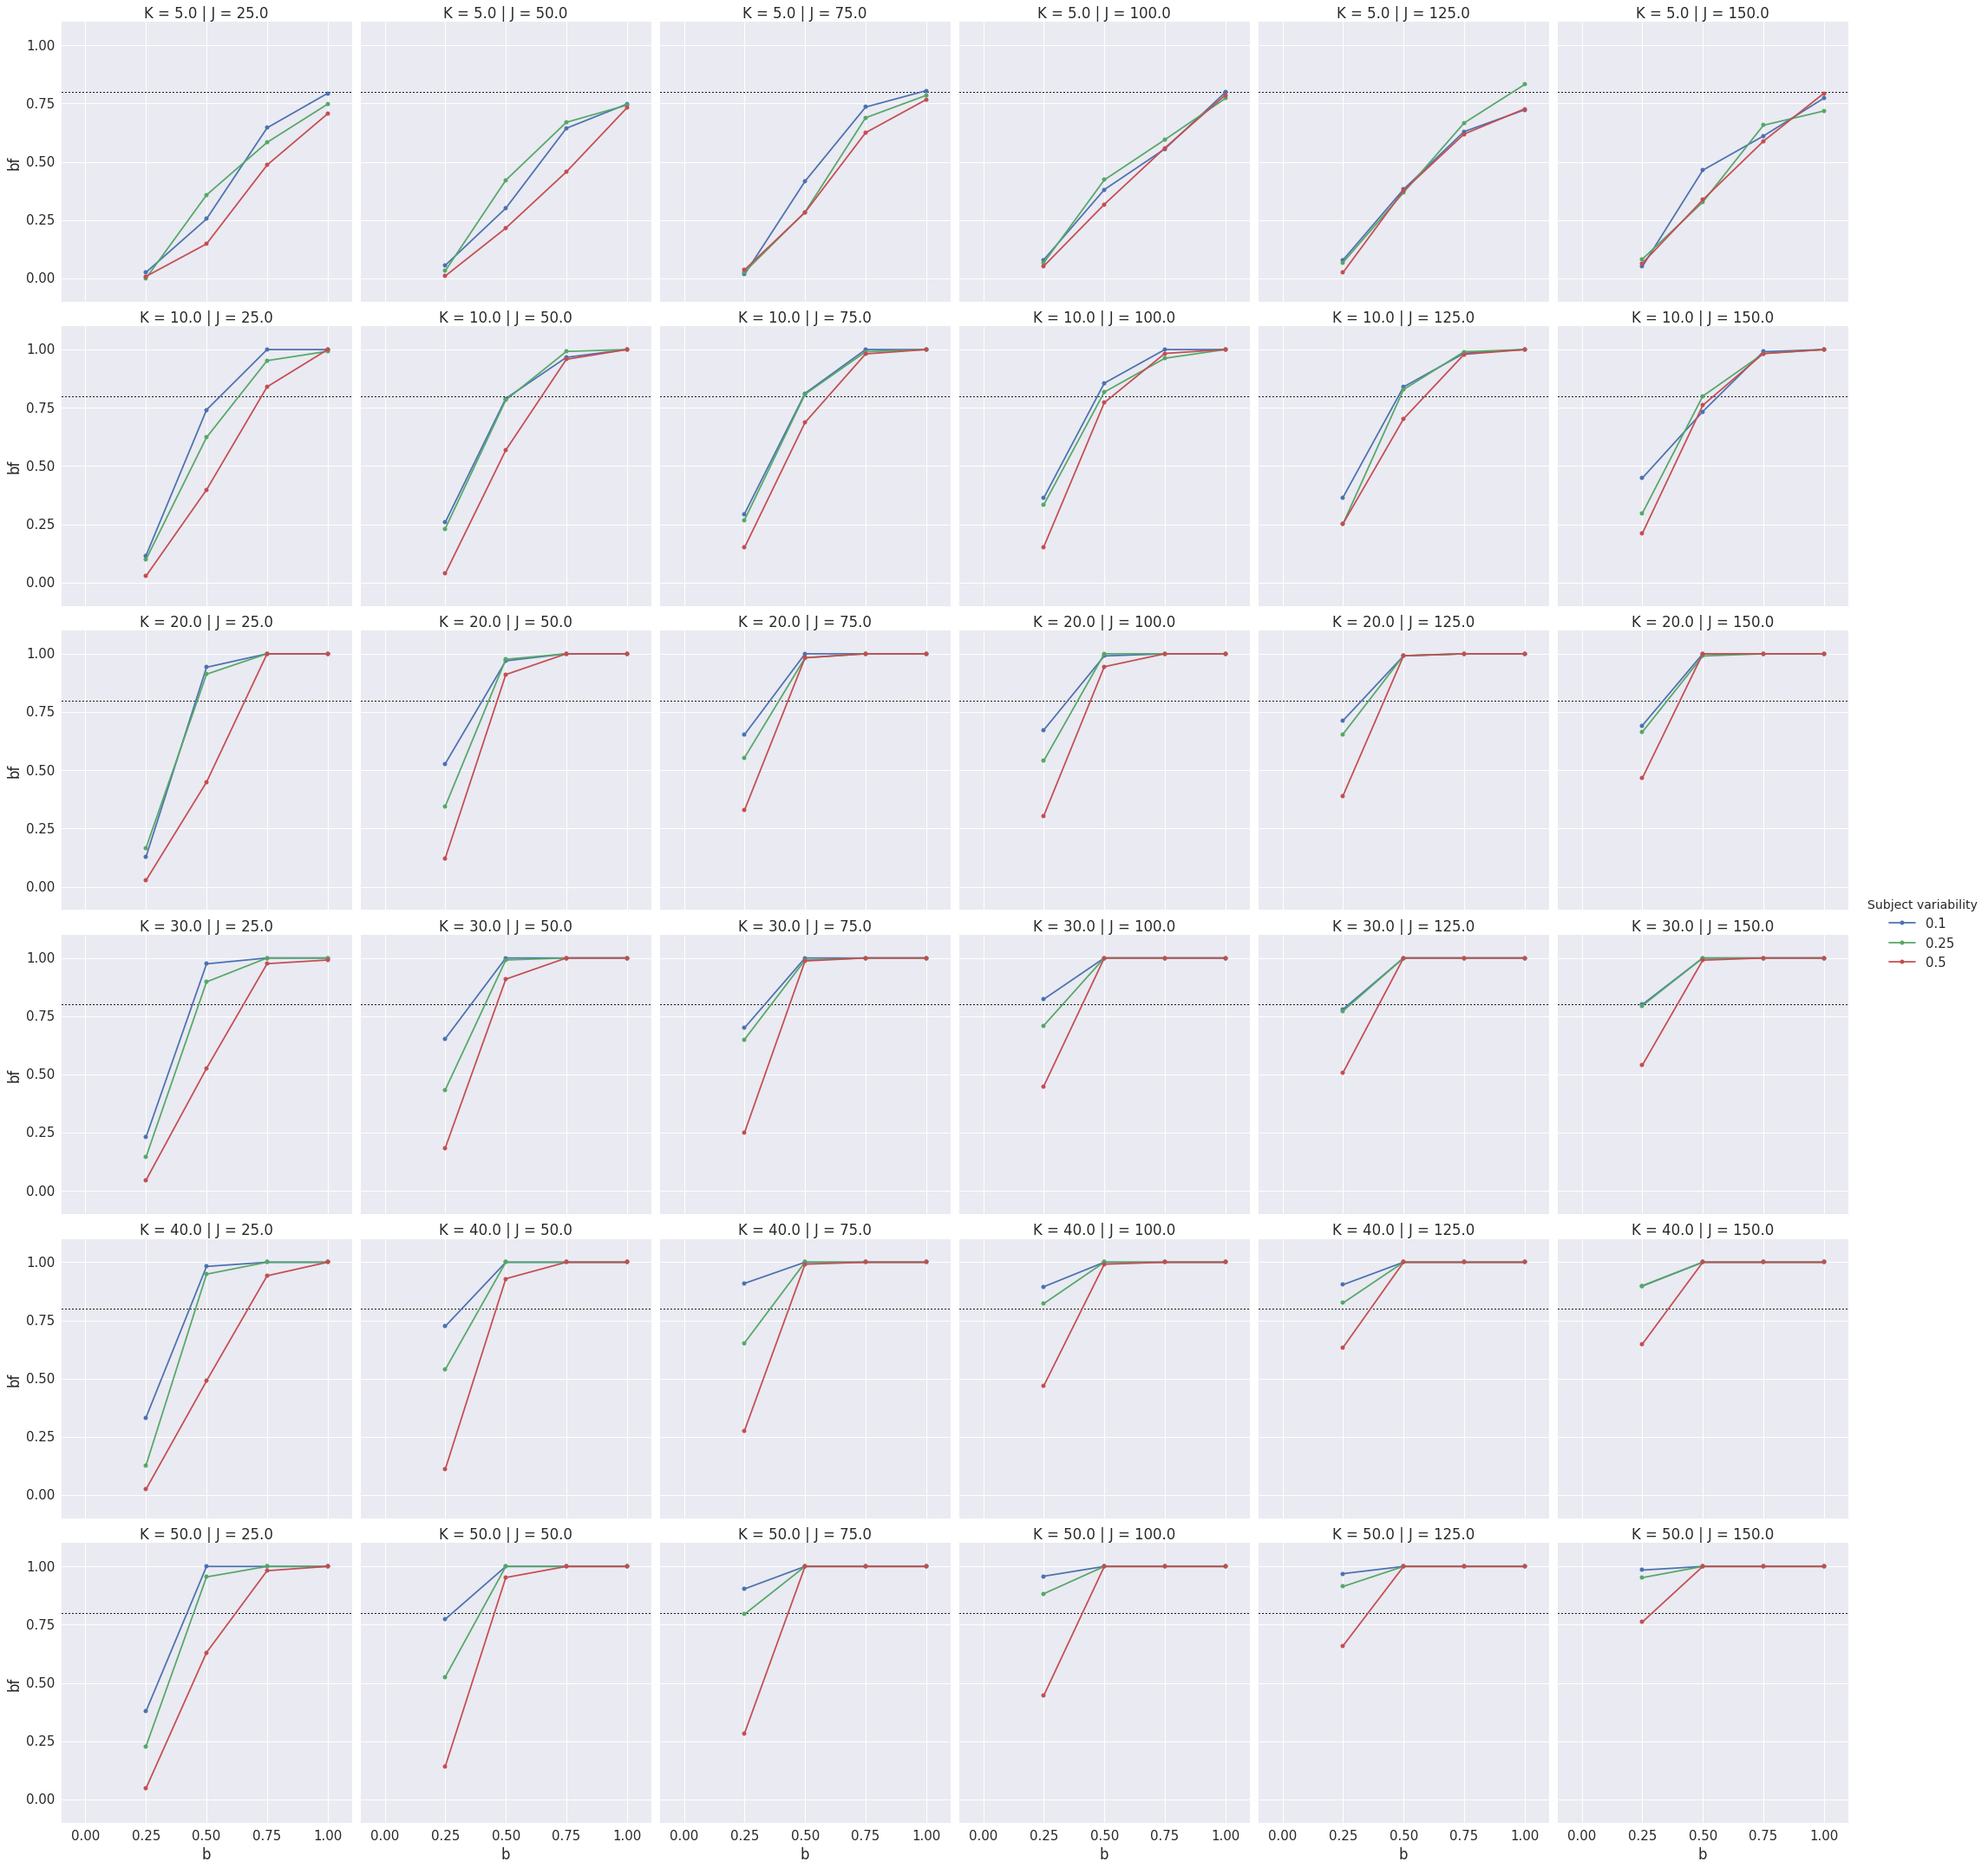

In [7]:
utils.powerplot(dataframe['kmin_3'], evidence_strength='strong');

Below, we look at the results from the same simulation as that just shown, and plot the results in a similar manner, but now where we set the threshold for the Bayes factor at $e^5$, or $2 \log BF > 10.0$. The conclusion from these plots is the same as above, i.e. if we have a high threshold for evidence against the null, we will have very low probability of seeing effects unless we use the largest numbers of different texts and subjects. 

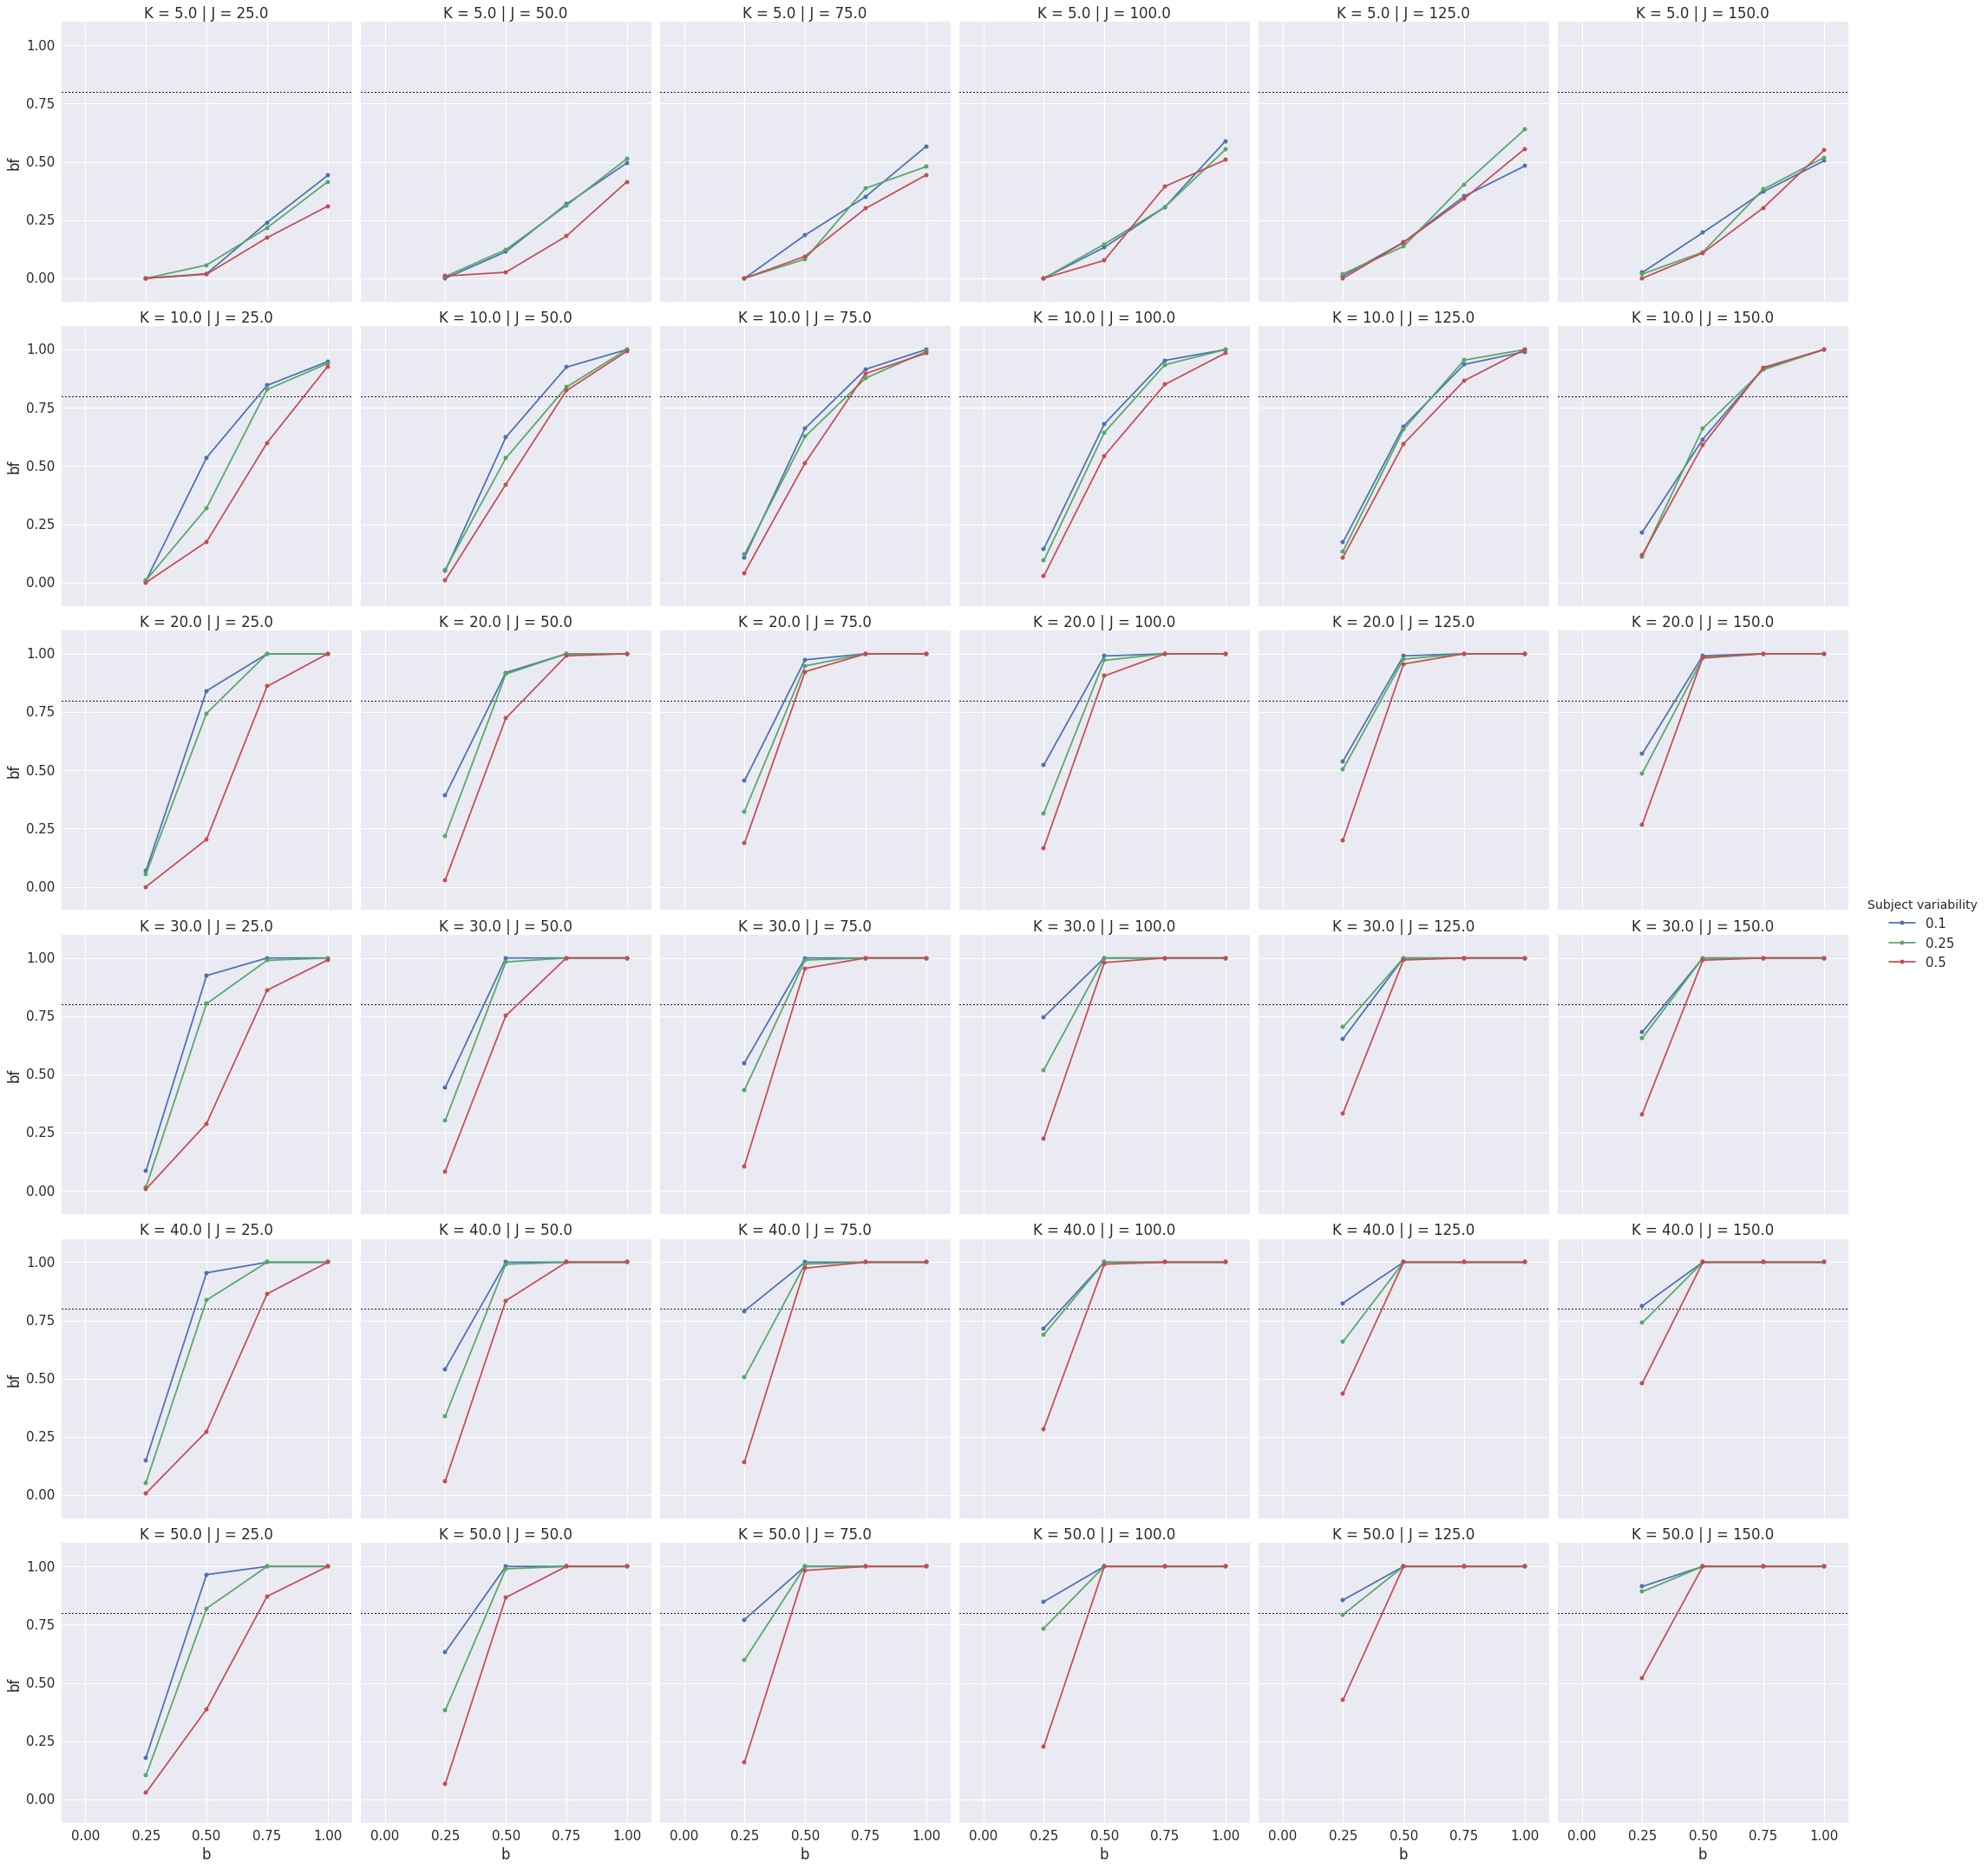

In [8]:
utils.powerplot(dataframe['kmin_3'], evidence_strength='very strong');

The two facetplots below present results in an identical manner to those of the previous two plots, but for the results of the second simulation, i.e. where $K$ ranged in value, but each subject was shown a random subset of 5 texts. The two facetplot show the probability of achieving the desired Bayes factors at the two different levels of the evidence threshold. The conclusions we draw are approximately the same as above, i.e. the case where each subject was shown a random subset of 3 texts.

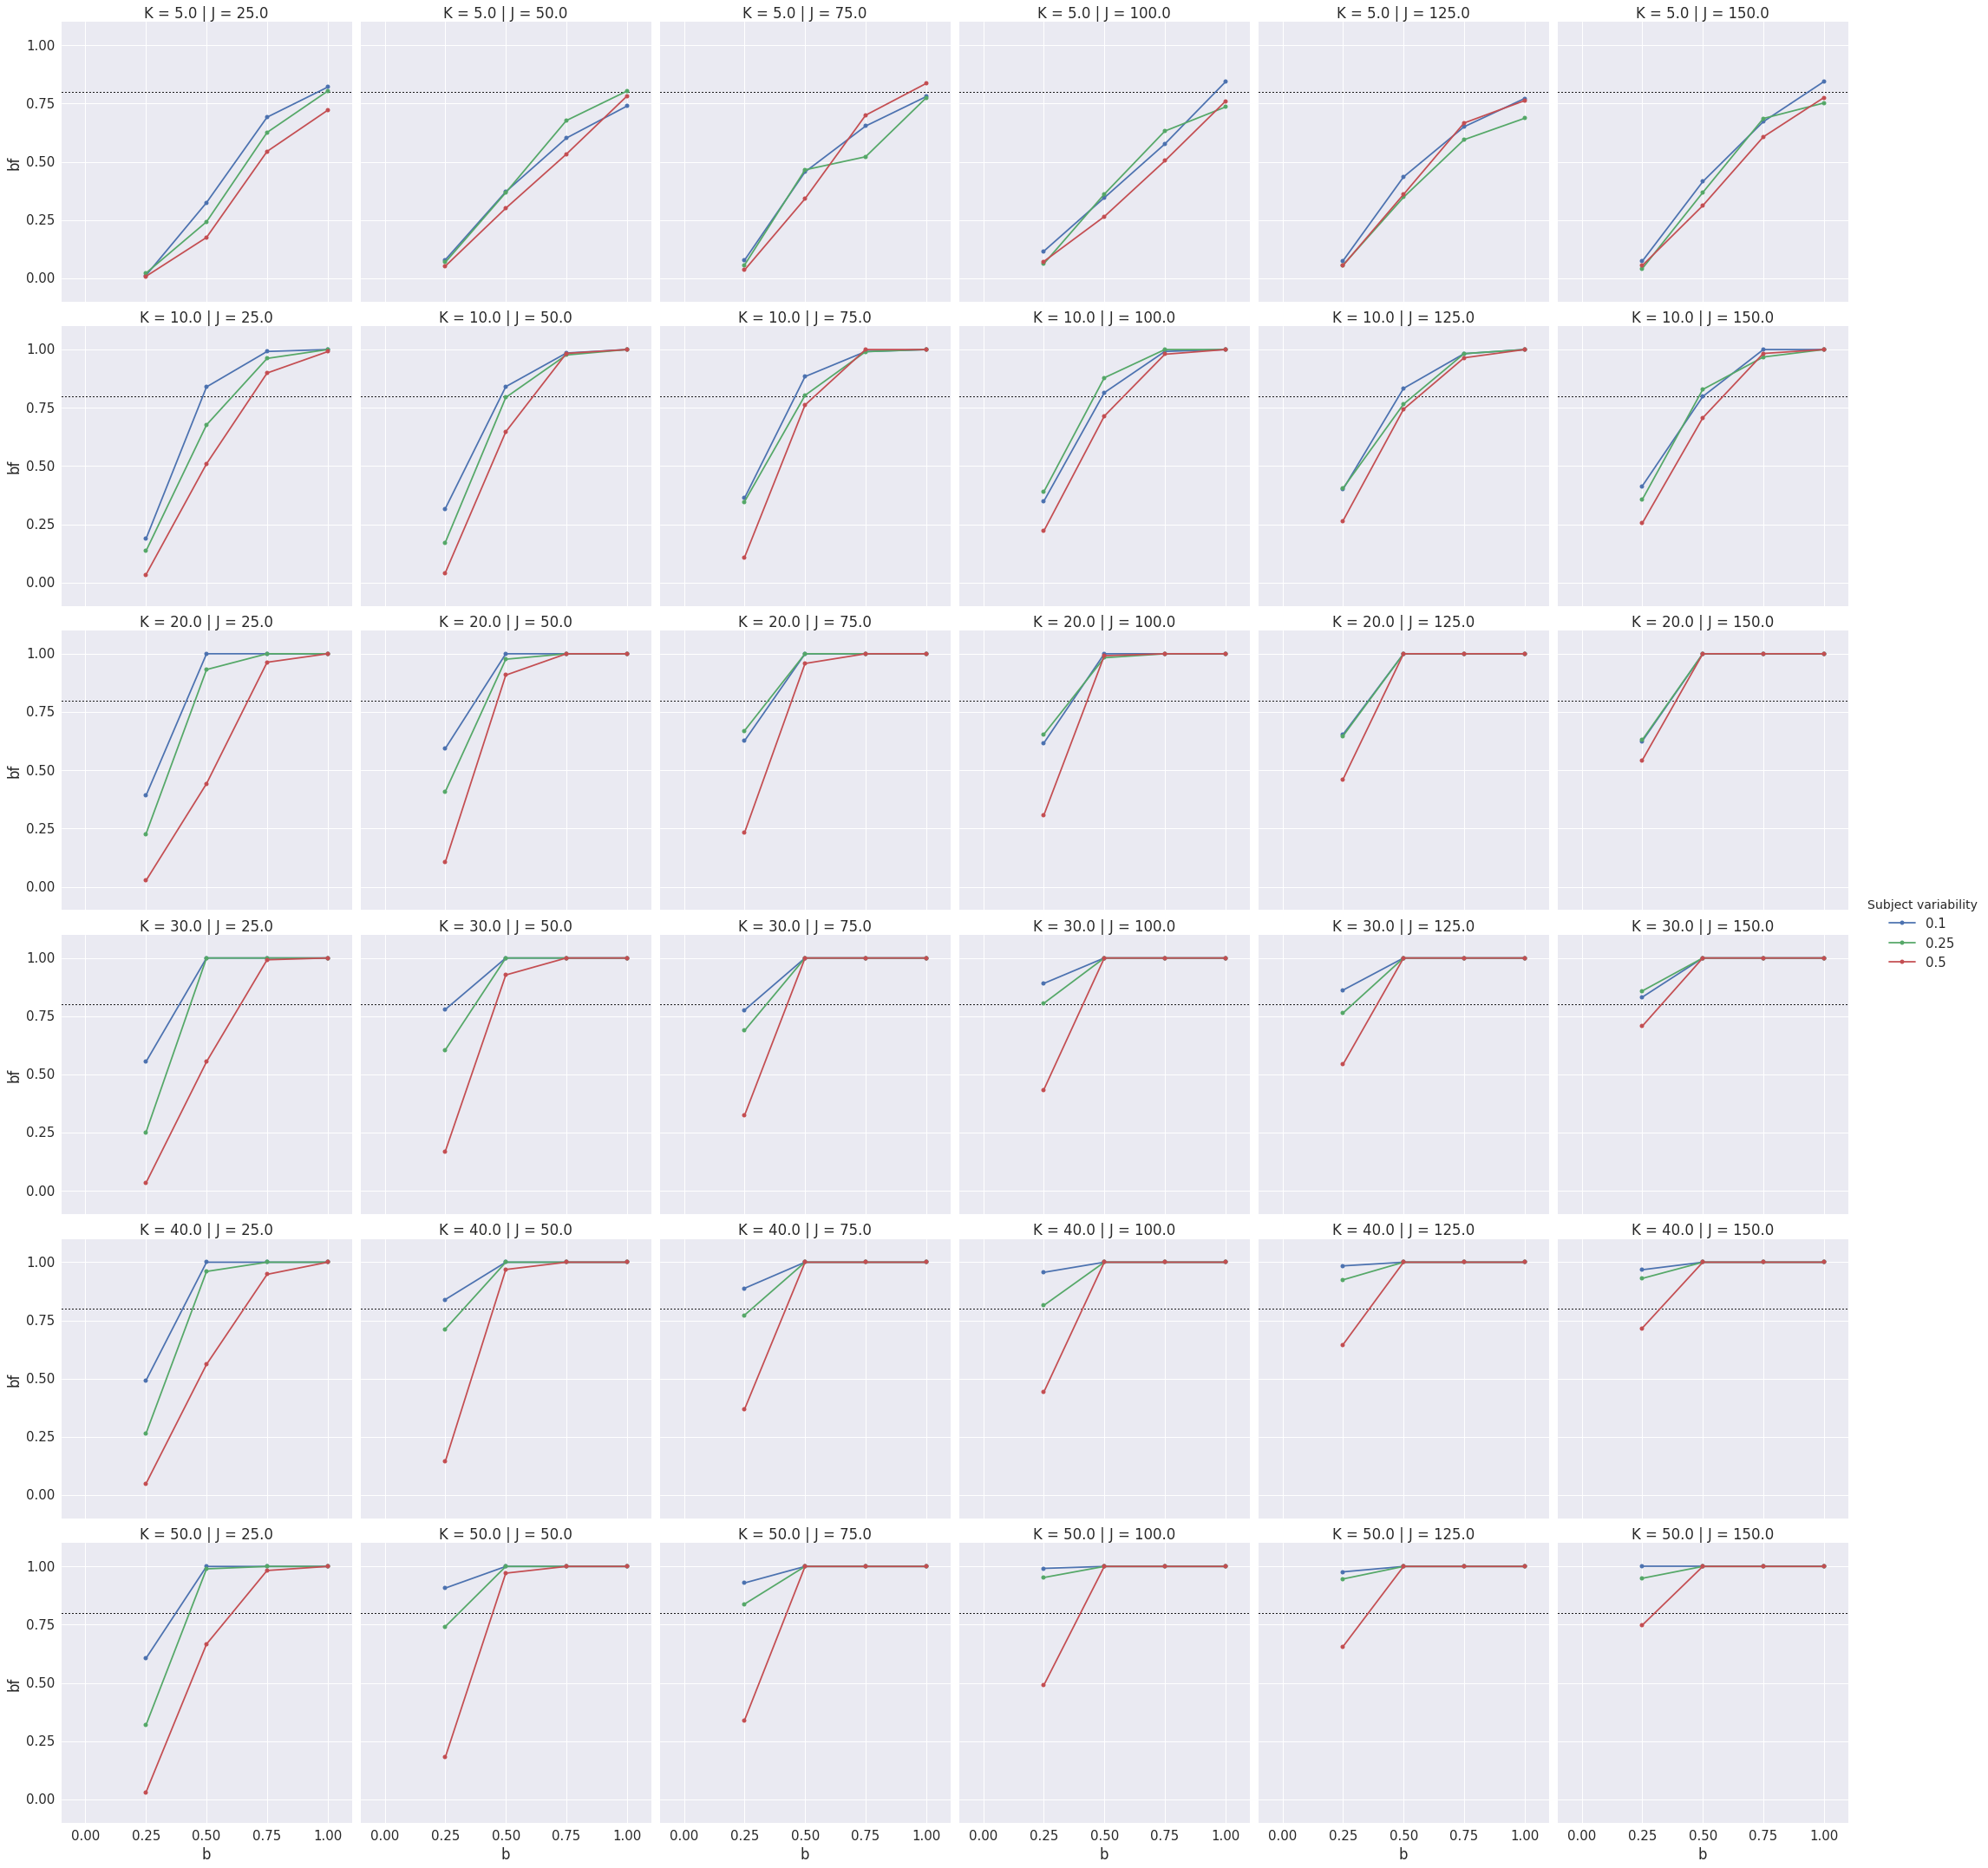

In [9]:
utils.powerplot(dataframe['kmin_5'], evidence_strength='strong');

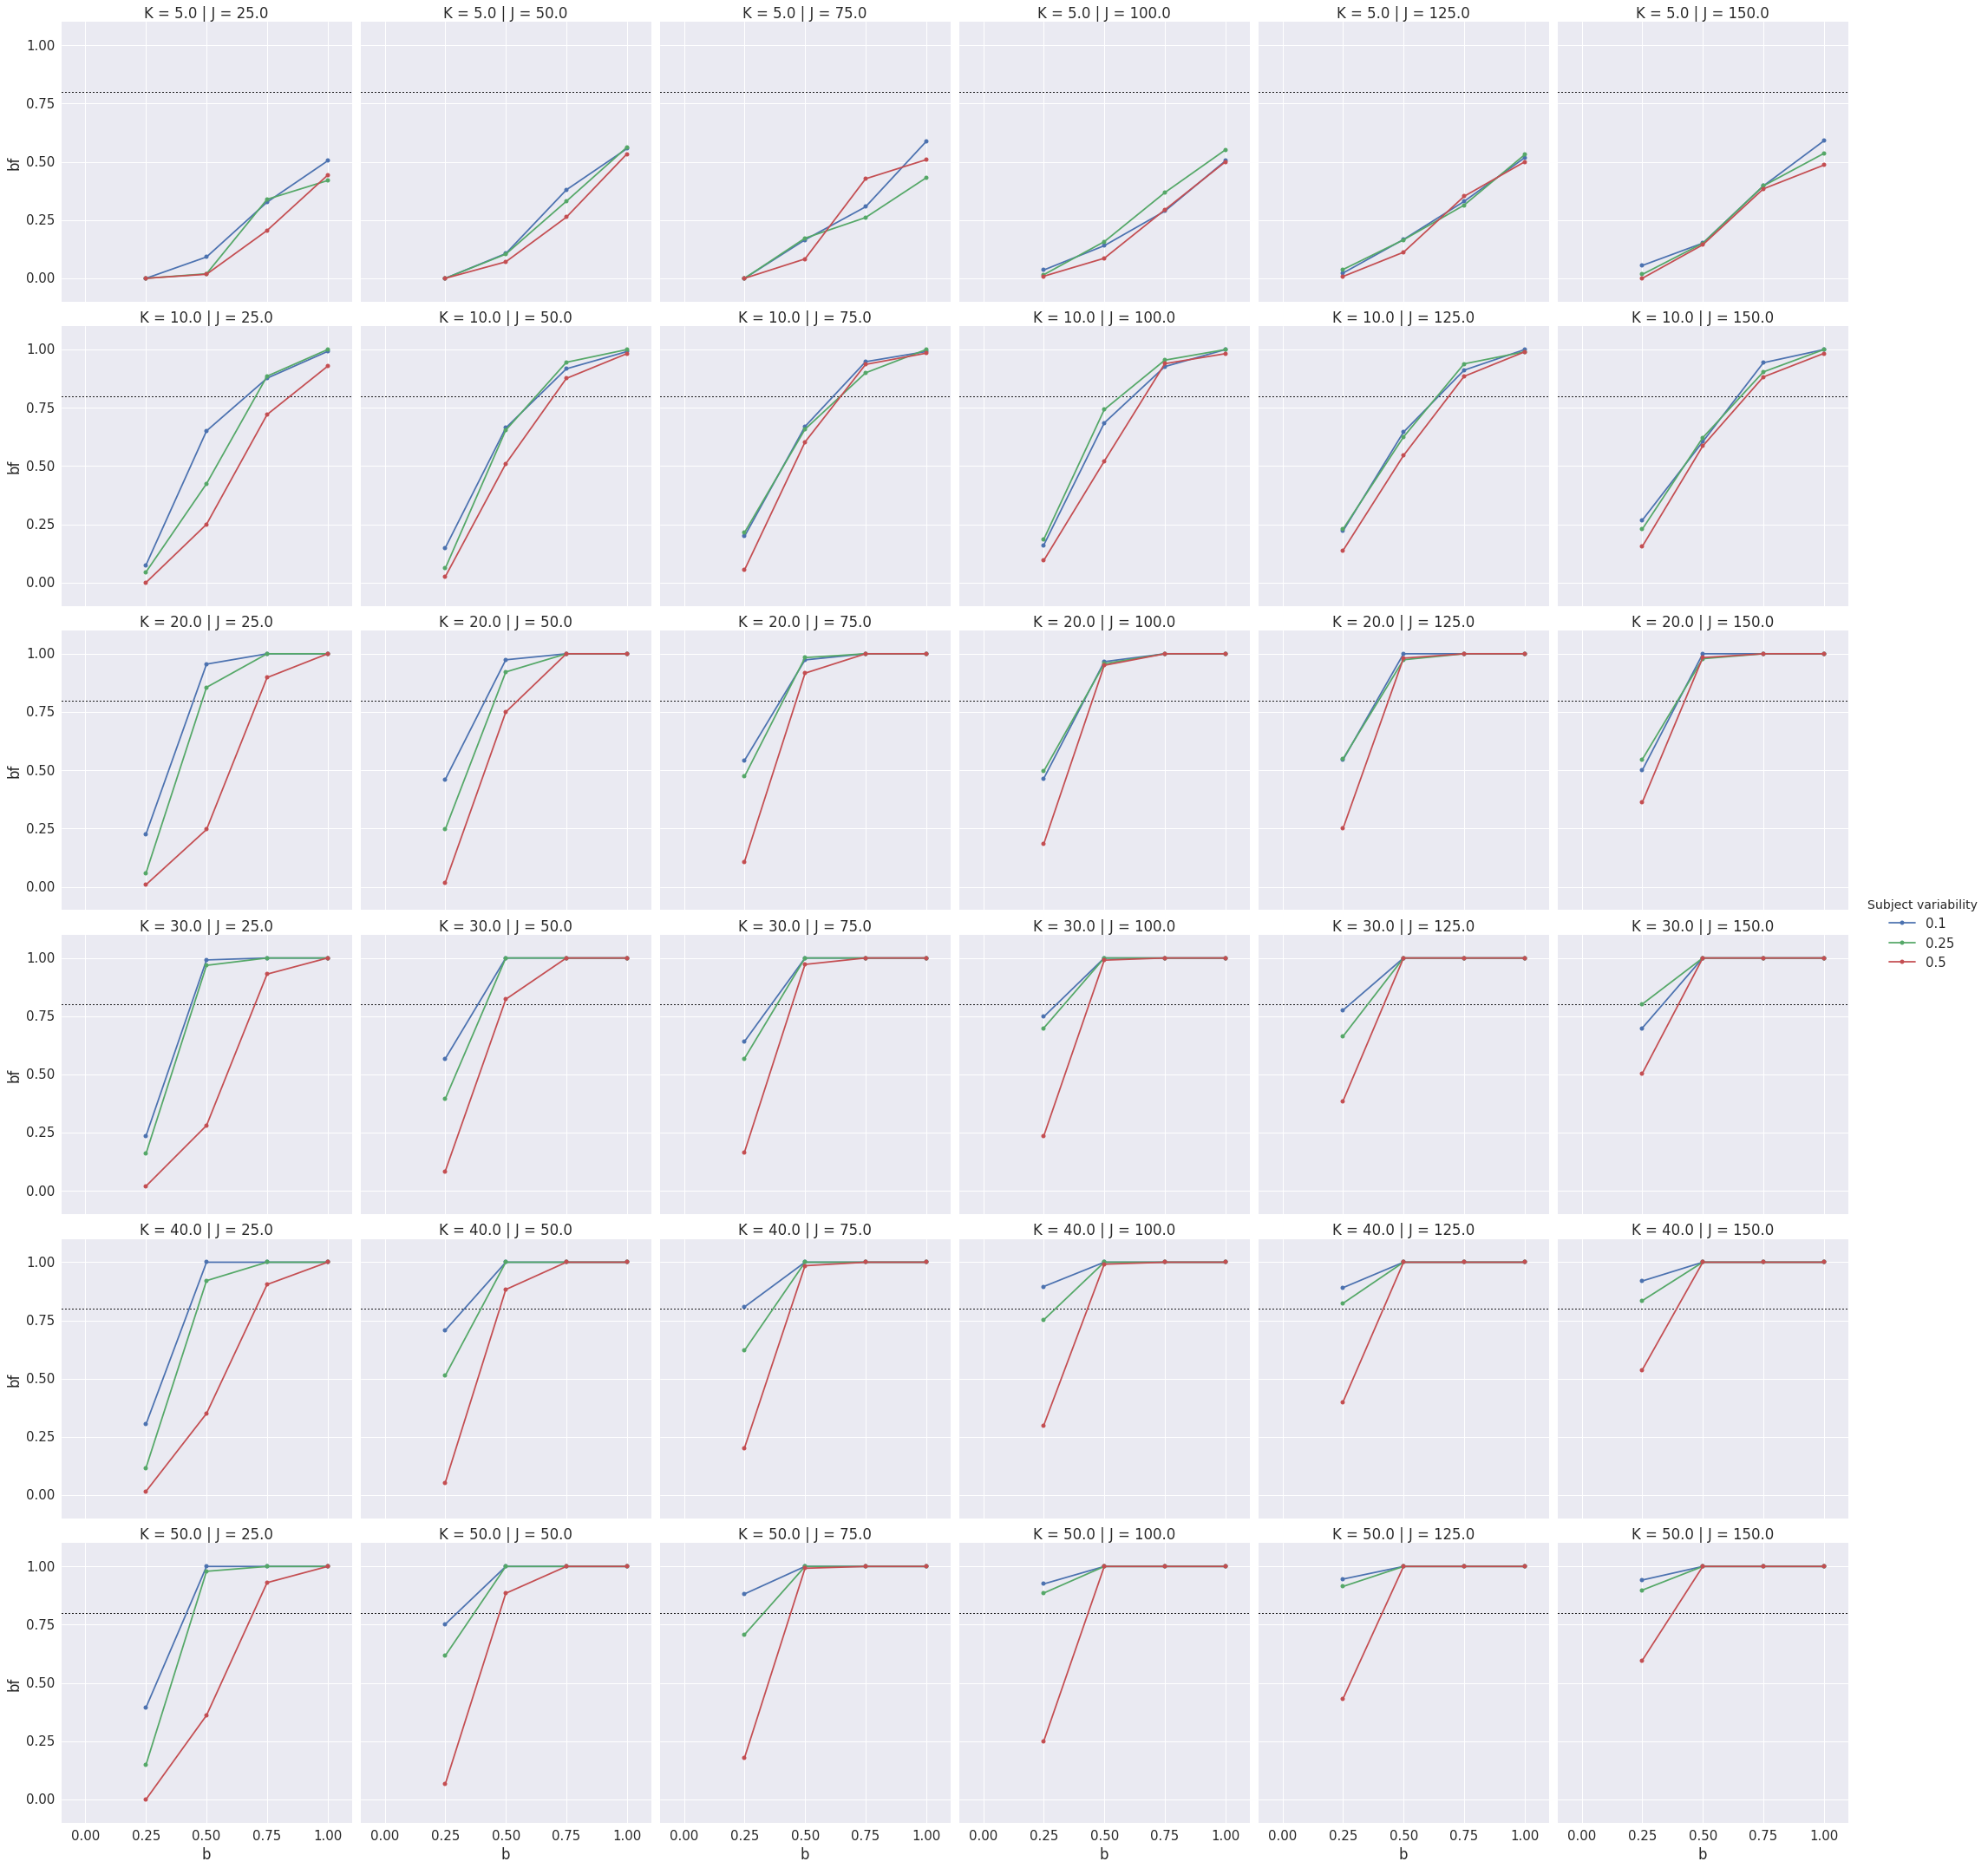

In [10]:
utils.powerplot(dataframe['kmin_5'], evidence_strength='very strong');

From the results shown above, we see that the key to achieving high power is to have a large variety of texts. What is particularly interesting is that this improvement in power occurs even if each subject sees only a very small subset of the total. This is important as it entails that only a relatively small amount of data from each subject is necessary so long as we have large amounts of variety in the texts and also a large total number of subjects.

The results of the final simulation show what would happen if we only had $K=10$ texts and each subject was shown all of them. This type of design is perhaps the most common design in cognitive psychology, i.e. all subjects see all stimuli and each subject is tested for about 40 mins to 1hr (this is how long the data collection of $K=10$ texts would take). What we see, however, is that even if we collected up to 1hr of data per subject and had all subjects see all texts, the relative lack of variety in the texts, i.e. the small total number of texts, would lead to considerably less power than if we used the same number of subjects and a large number of texts even if each subject only a small subject, around 3, of them.

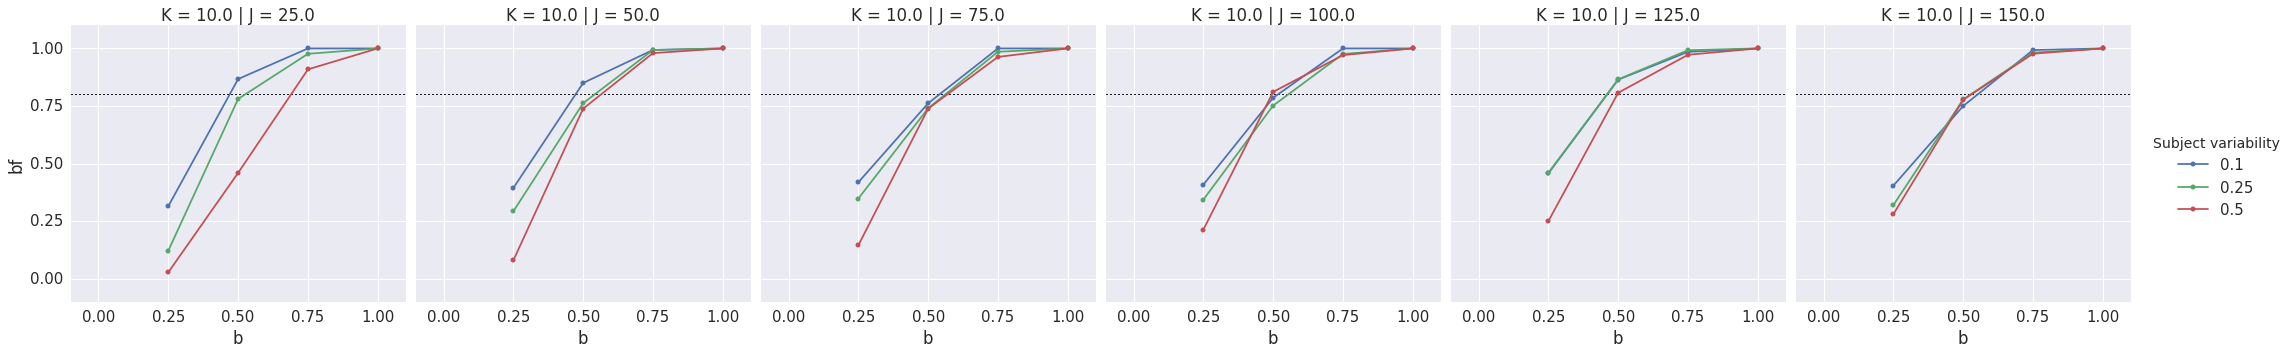

In [11]:
utils.powerplot(dataframe['kmax_kmin_10'], evidence_strength='strong');

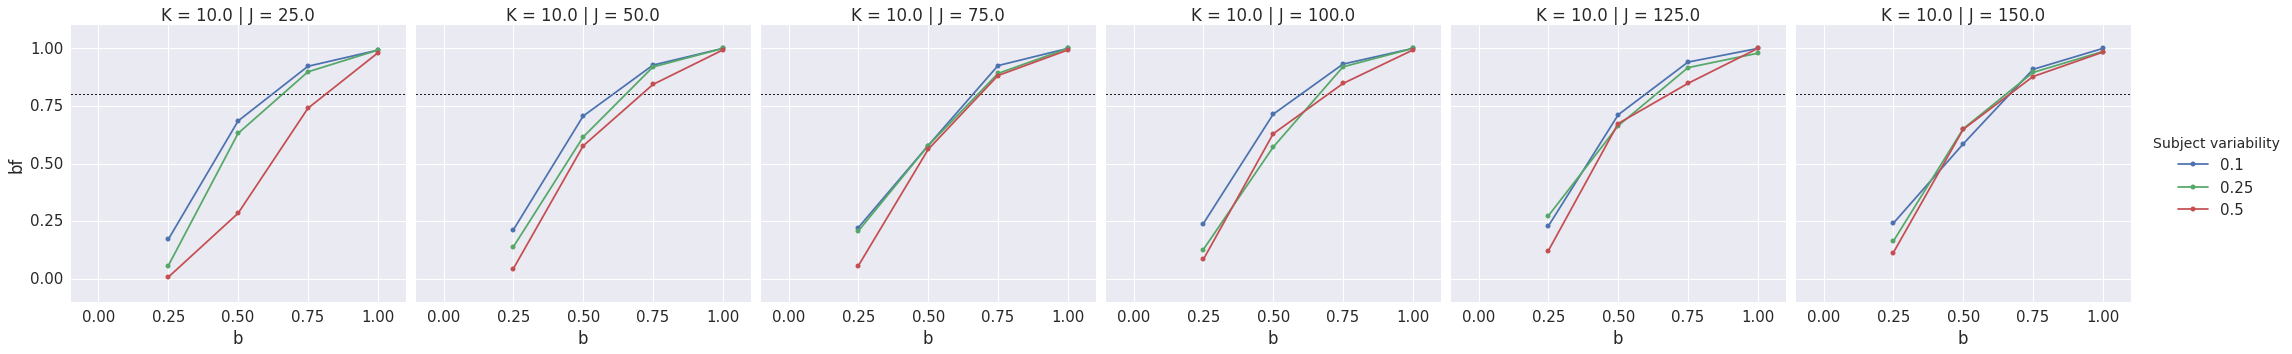

In [12]:
utils.powerplot(dataframe['kmax_kmin_10'], evidence_strength='very strong');